# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [ ]:
The dataset covers 17 telemarketing campaigns run by a Portuguese bank from May 2008 to November 2010.

Each row represents one phone contact with a customer about subscribing to a term deposit.

Two dataset sizes exist: 41,188 records (full) and 4,521 records (filtered).

Features fall into four groups:

Client attributes: age, job, marital status, education, loans, etc.

Campaign attributes: contact type, month/day, call duration, number of contacts, previous outcomes.

Economic indicators: employment variation, CPI, confidence index, Euribor rate, number of employees.

Target: whether the customer subscribed (y).

The task is a binary classification problem with a highly imbalanced target (≈11% “yes”).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [73]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [74]:
import pandas as pd

In [75]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [76]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [78]:
#Check for missing values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [16]:
print("Several categorical features contain missing values encoded as 'unknown'. Categorical variables should remain as strings and later be one‑hot encoded.")

Several categorical features contain missing values encoded as 'unknown'. Categorical variables should remain as strings and later be one‑hot encoded.


### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

In [ ]:
Business Objective
The goal of this project is to help the bank improve the effectiveness of its telemarketing campaigns for term deposit subscriptions. By analyzing historical campaign data and comparing multiple classification models, the bank aims to identify which customers are most likely to subscribe. This enables more efficient targeting, reduces unnecessary calls, and increases overall campaign success.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [79]:
print(df['y'].unique())

# Target Encoding as numeric
df['y'] = df['y'].str.lower().map({'yes': 1, 'no': 0})

['no' 'yes']


In [80]:
# Feature Selection
# Drop the 'duration' column since it is not available at the time of prediction.
df_processed = df.drop('duration', axis=1)

In [81]:
print("There are 2 features that have a cyclic relationship, namely the month column and the day_of_week column. One-hot encoding would not preserve it's cyclic nature, so we will go with the cyclic encoding - which uses it's sin and cos values instead ")

There are 2 features that have a cyclic relationship, namely the month column and the day_of_week column. One-hot encoding would not preserve it's cyclic nature, so we will go with the cyclic encoding - which uses it's sin and cos values instead 


In [82]:
# Define cyclical features and their orders
CYCLICAL_FEATURES = {
    'month': ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'],
    'day_of_week': ['mon', 'tue', 'wed', 'thu', 'fri']
}

# Apply cyclical transformation
for feature, order in CYCLICAL_FEATURES.items():
    # Map categories to 0-based integers
    mapping = {val: i for i, val in enumerate(order)}
    df_processed[f'{feature}_num'] = df_processed[feature].map(mapping)
    
    # Get period
    P = len(order)
    
    # Compute sin and cos components
    df_processed[f'{feature}_sin'] = np.sin(2 * np.pi * df_processed[f'{feature}_num'] / P)
    df_processed[f'{feature}_cos'] = np.cos(2 * np.pi * df_processed[f'{feature}_num'] / P)

# Drop original categorical cyclical columns and intermediate numeric columns
df_processed = df_processed.drop(list(CYCLICAL_FEATURES.keys()) + 
                                 [f'{f}_num' for f in CYCLICAL_FEATURES.keys()], axis=1)

# Remaining categorical features for one-hot encoding
nominal_categorical_cols = [
    'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'
]

# Apply one-hot encoding
df_encoded = pd.get_dummies(df_processed, columns=nominal_categorical_cols, drop_first=True)

# Check the processed DataFrame
df_encoded.sample(5)

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,...,education_unknown,default_unknown,default_yes,housing_unknown,housing_yes,loan_unknown,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success
24598,40,2,999,0,-0.1,93.200,-42.0,4.191,5195.8,0,...,False,True,False,True,False,True,False,False,True,False
986,34,1,999,0,1.1,93.994,-36.4,4.856,5191.0,0,...,False,False,False,False,True,False,False,True,True,False
3694,46,1,999,0,1.1,93.994,-36.4,4.859,5191.0,0,...,False,False,False,False,False,False,False,True,True,False
28879,39,1,999,0,-1.8,93.075,-47.1,1.410,5099.1,0,...,True,True,False,False,True,False,False,False,True,False
22883,42,2,999,0,1.4,93.444,-36.1,4.965,5228.1,0,...,False,False,False,False,False,False,False,False,True,False


In [83]:
#Check class imbalance
print(df_encoded['y'].value_counts(normalize=True))

y
0    0.887346
1    0.112654
Name: proportion, dtype: float64


In [84]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 44 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41188 non-null  int64  
 1   campaign                       41188 non-null  int64  
 2   pdays                          41188 non-null  int64  
 3   previous                       41188 non-null  int64  
 4   emp.var.rate                   41188 non-null  float64
 5   cons.price.idx                 41188 non-null  float64
 6   cons.conf.idx                  41188 non-null  float64
 7   euribor3m                      41188 non-null  float64
 8   nr.employed                    41188 non-null  float64
 9   y                              41188 non-null  int64  
 10  month_sin                      41188 non-null  float64
 11  month_cos                      41188 non-null  float64
 12  day_of_week_sin                41188 non-null 

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [85]:
X = df_encoded.drop('y', axis=1)
y = df_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [86]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Use the DummyClassifier constructor method for creating a baseline and then fit it on the training data.
dummy = DummyClassifier(strategy="most_frequent", random_state=42)
dummy.fit(X_train, y_train)

#Use this dummy model to predict the testing data.
y_pred_dummy = dummy.predict(X_test)

print("Scores for Baseline Model:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_dummy):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_dummy, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_dummy):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_dummy):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dummy))

Scores for Baseline Model:
Accuracy:  0.8874
Precision: 0.0000
Recall:    0.0000
F1 Score:  0.0000

Confusion Matrix:
[[7310    0]
 [ 928    0]]


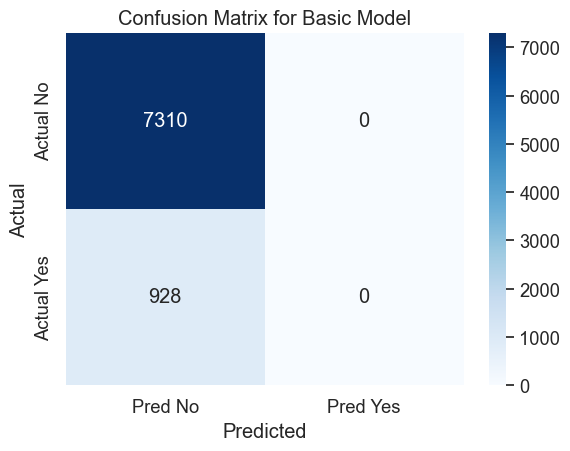

In [87]:
#Let's create a visual representation of the confusion matrix

confusion_matrix_baseline = confusion_matrix(y_test, y_pred_dummy)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No','Pred Yes'], yticklabels=['Actual No','Actual Yes'])
plt.title("Confusion Matrix for Basic Model")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/confusion_matrix_basic_model.png', dpi=300)
plt.show()

In [ ]:
The baseline model achieves a high accuracy of 0.8874, but all other metrics—precision, recall, and F1 score—are 0.0000. The confusion matrix shows that the model predicts every customer as “No”, resulting in:

7310 true negatives

928 false negatives

0 true positives

0 false positives

This behavior is expected because the baseline simply predicts the majority class, and in this dataset, most customers do not subscribe to a term deposit. While this strategy yields high accuracy due to class imbalance, it completely fails to identify any actual subscribers.

What this means
The baseline model is not useful for the business objective, which requires identifying customers likely to say “yes.”

Accuracy alone is misleading in imbalanced datasets.

Any meaningful model must outperform the baseline by correctly identifying at least some positive cases (improving recall and F1 score).

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [88]:
# Let's use logistic regression to build a basic model on our data. Let's create a pipeline that uses a StandardScaler
# for the scaling process and LogisticRegression for the modeling process.

log_reg = Pipeline([
    ('scaler', StandardScaler()), 
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model on the training data
log_reg.fit(X_train, y_train)

,steps,"[('scaler', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


In [89]:
# Use the logistic regression model to predict the testing data
y_pred_lr = log_reg.predict(X_test)

### Problem 9: Score the Model

What is the accuracy of your model?

In [90]:
#Now, let's look at the accuracy of the model
print("Scores for Logistic Regression Model:")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_lr):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_lr, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_lr):.4f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_lr):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))

Scores for Logistic Regression Model:
Accuracy:  0.9006
Precision: 0.6940
Recall:    0.2101
F1 Score:  0.3226

Confusion Matrix:
[[7224   86]
 [ 733  195]]


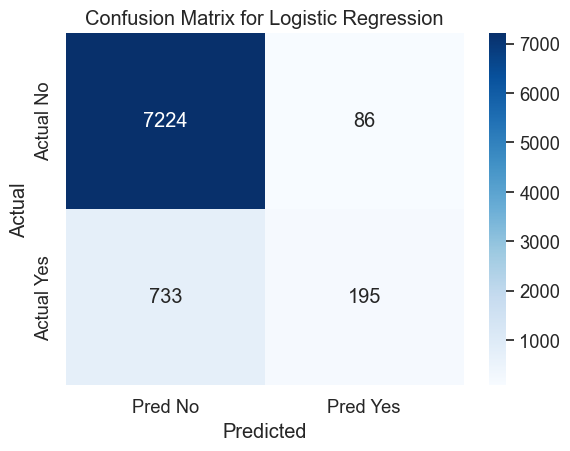

In [91]:
#Let's create a visual representation of the confusion matrix

confusion_matrix_log_reg = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,5))
sns.heatmap(confusion_matrix_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=['Pred No','Pred Yes'], yticklabels=['Actual No','Actual Yes'])
plt.title("Confusion Matrix for Logistic Regression")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('images/confusion_matrix_logistic_regression.png', dpi=300)
plt.show()

In [ ]:
Here are the key take-aways for the model that uses Logistic Regression:

Accuracy improved to 0.9006, up from the baseline of 0.8874.

Precision is strong at 0.6940, meaning nearly 7 out of 10 predicted subscribers were correct.

Recall remains low at 0.2101, capturing only 21% of actual subscribers.

F1 Score is 0.3226, reflecting the imbalance between high precision and low recall.

The model correctly identified 195 true positives, compared to 0 in the baseline.

It produced 86 false positives, a small increase relative to the dataset size.

It still missed 733 actual subscribers (false negatives), showing under‑detection of the positive class.

True negatives remain high at 7,224, consistent with the majority‑class distribution.

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [92]:
# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Use a Column transformer that uses a StandardScaler and a OneHotEncoder to preprocess these columns.
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ]
)

# Define the models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVC': SVC()
}

results = []

print("Starting model training...\n")

for name, model in models.items():
    print(f"Training {name}...")
    start = time.time()
    
    model.fit(X_train, y_train)
    
    end = time.time()
    print(f"→ Finished training {name} in {round(end - start, 4)} seconds")
    
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))
    
    print(f"→ Train Accuracy: {round(train_acc, 4)}")
    print(f"→ Test Accuracy:  {round(test_acc, 4)}\n")
    
    results.append({
        "Model": name,
        "Train Time (sec)": round(end - start, 4),
        "Train Accuracy": round(train_acc, 4),
        "Test Accuracy": round(test_acc, 4)
    })

print("All models trained.\n")

results_df = pd.DataFrame(results)
results_df['Version'] = 'Default'
results_df

Starting model training...

Training Logistic Regression...
→ Finished training Logistic Regression in 0.1055 seconds
→ Train Accuracy: 0.8995
→ Test Accuracy:  0.9003

Training KNN...
→ Finished training KNN in 0.0112 seconds
→ Train Accuracy: 0.9136
→ Test Accuracy:  0.8934

Training Decision Tree...
→ Finished training Decision Tree in 0.169 seconds
→ Train Accuracy: 0.9954
→ Test Accuracy:  0.8384

Training SVC...
→ Finished training SVC in 57.6196 seconds
→ Train Accuracy: 0.9042
→ Test Accuracy:  0.902

All models trained.



,Model,Train Time (sec),Train Accuracy,Test Accuracy,Version
0,Logistic Regression,0.1055,0.8995,0.9003,Default
1,KNN,0.0112,0.9136,0.8934,Default
2,Decision Tree,0.1690,0.9954,0.8384,Default
3,SVC,57.6196,0.9042,0.9020,Default


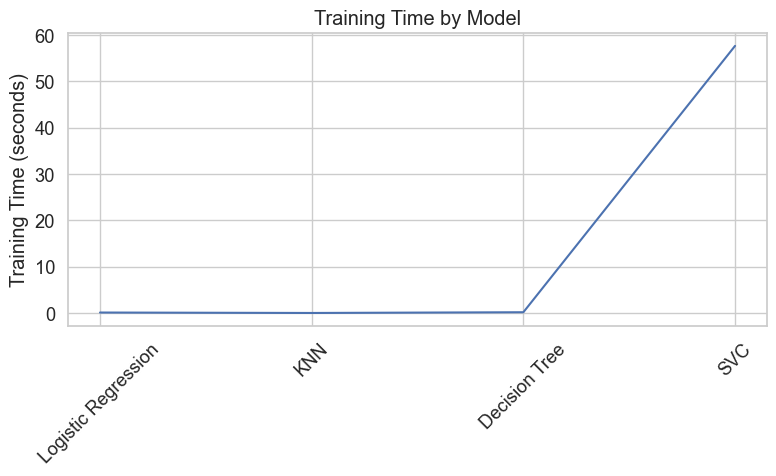

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Bar Chart to display the Training Time for each model
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=results_df,
    x="Model",
    y="Train Time (sec)",
    legend=False
)

plt.title("Training Time by Model")
plt.xlabel("")
plt.ylabel("Training Time (seconds)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


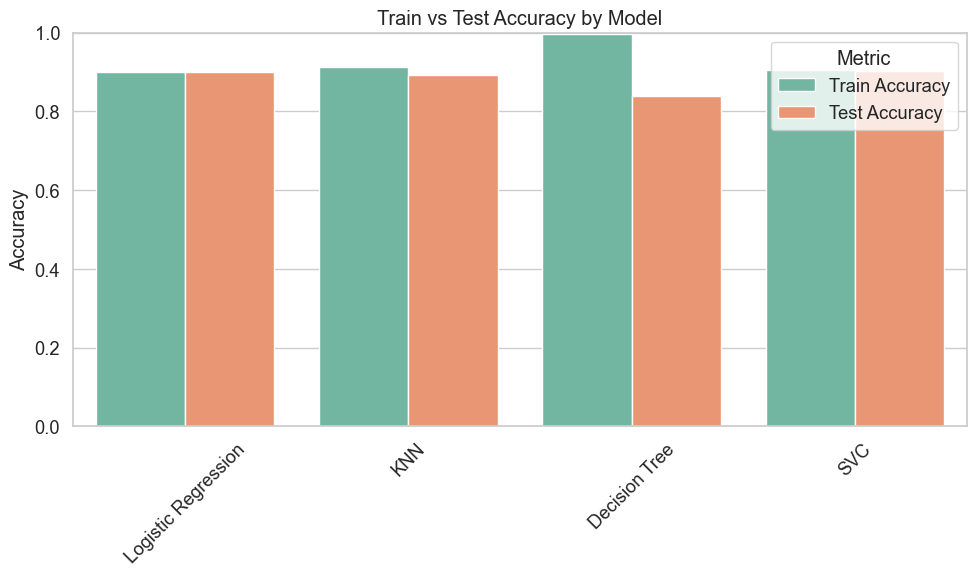

In [98]:
# Bar Chart to display the Training vs Test Accuracy for each model

# Melt accuracy columns for grouped plotting
acc_df = results_df.melt(
    id_vars="Model",
    value_vars=["Train Accuracy", "Test Accuracy"],
    var_name="Metric",
    value_name="Accuracy"
)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=acc_df,
    x="Model",
    y="Accuracy",
    hue="Metric",
    palette="Set2"
)

plt.title("Train vs Test Accuracy by Model")
plt.xlabel("")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.tight_layout()
plt.show()


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [ ]:
	• We will improve our models by tuning hyperparameters using GridSearchCV or RandomizedSearchCV.
	• We will shift our evaluation away from accuracy and toward recall, precision, F1, and AUC metrics.
	• These steps help us build models that better support the business objective: identifying customers most likely to subscribe to a term deposit.


In [99]:
import itertools
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Let's create a pipeline for Logistic Regression — SMOTE
lr_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(max_iter=500, solver='liblinear', random_state=42))
])

lr_param_grid = {
    'model__C': np.logspace(-2, 2, 6),
    'model__penalty': ['l1', 'l2']
}

# Let's create a pipeline for KNN — SMOTE
knn_pipe = ImbPipeline([
    ('smote', SMOTE(random_state=42, sampling_strategy=0.8)),
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

knn_param_grid = {
    'model__n_neighbors': range(3, 15, 2),
    'model__weights': ['uniform', 'distance']
}

# Let's create a pipeline for Decision Tree. We will set the class_weight parameter to 'balanced'.
# We will not use SMOTE in this case to improve performance.
dt_pipe = Pipeline([
    ('model', DecisionTreeClassifier(class_weight='balanced', random_state=42))
])

dt_param_grid = {
    'model__max_depth': [None, 5, 10, 15],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 5]
}

# Let's create a pipeline for SVC. We will set the class_weight parameter to 'balanced'.
# We will not use SMOTE as oversampling slows SVC.
svc_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

svc_param_grid = {
    'model__C': np.logspace(-2, 2, 6)
}

# Combine all models and grids
models_grids = {
    'Logistic Regression': (lr_pipe, lr_param_grid),
    'KNN': (knn_pipe, knn_param_grid),
    'Decision Tree': (dt_pipe, dt_param_grid),
    'SVC': (svc_pipe, svc_param_grid)
}

# Function to count the number of iterations 
def count_param_combinations(param_grid):
    """Count all unique parameter combinations."""
    keys, values = zip(*param_grid.items())
    combos = list(itertools.product(*values))
    return len(combos)

# Let's use RandomizedSearchCV instead of GridSearchCV for Each Model for better performance

results = []
best_models = {}

for name, (pipe, param_grid) in models_grids.items():
    print(f"\n Running RandomizedSearchCV for {name}...")

    total_combos = count_param_combinations(param_grid)
    n_iter = min(15, total_combos)  # Automatically adjusts to avoid warning

    rs = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=n_iter,
        scoring={'f1': 'f1'},
        refit='f1',
        cv=3,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    start_time = time.time()
    rs.fit(X_train, y_train)
    end_time = time.time()

    train_time = end_time - start_time
    train_acc = accuracy_score(y_train, rs.best_estimator_.predict(X_train))
    test_acc = accuracy_score(y_test, rs.best_estimator_.predict(X_test))

    results.append({
        'Model': name,
        'Train Time (sec)': round(train_time, 2),
        'Train Accuracy': round(train_acc, 4),
        'Test Accuracy': round(test_acc, 4)
    })

    best_models[name] = rs
    print(f"{name} complete.")

# Dataframe for performance
df_results_improved = pd.DataFrame(results)
df_results_improved = df_results_improved[['Model', 'Train Time (sec)', 'Train Accuracy', 'Test Accuracy']]
df_results_improved['Version'] = 'Tuned'
print(df_results_improved)


 Running RandomizedSearchCV for Logistic Regression...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Logistic Regression complete.

 Running RandomizedSearchCV for KNN...
Fitting 3 folds for each of 12 candidates, totalling 36 fits
KNN complete.

 Running RandomizedSearchCV for Decision Tree...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
Decision Tree complete.

 Running RandomizedSearchCV for SVC...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
SVC complete.
                 Model  Train Time (sec)  Train Accuracy  Test Accuracy  \
0  Logistic Regression             14.51          0.8273         0.8319   
1                  KNN             14.77          0.8449         0.8071   
2        Decision Tree              1.19          0.8458         0.8495   
3                  SVC              2.03          0.7808         0.7879   

  Version  
0   Tuned  
1   Tuned  
2   Tuned  
3   Tuned  


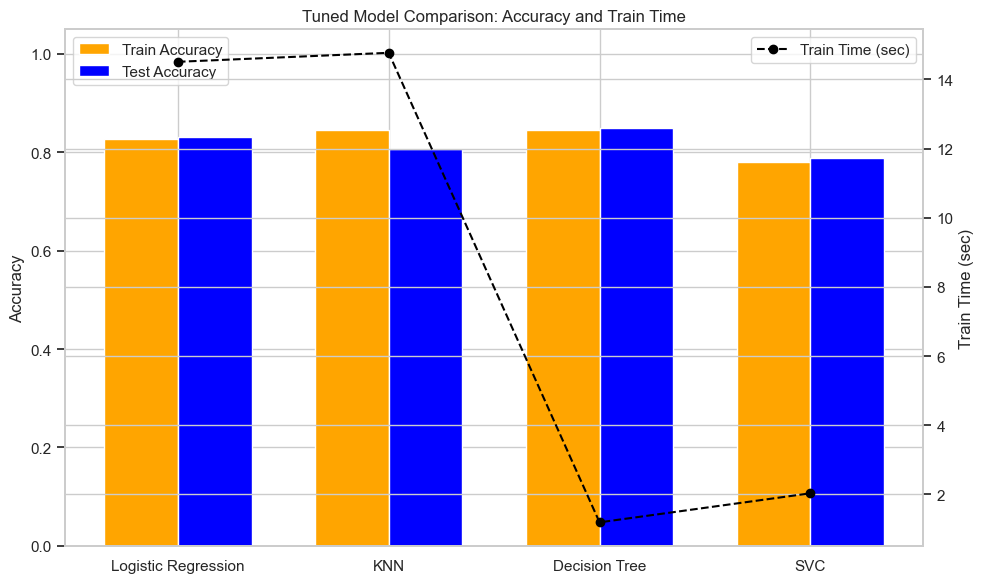

In [101]:
# Let's plot these results on a graph.
sns.set(style="whitegrid")

# Create a figure with subplots
fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Train and Test Accuracy as bars
width = 0.35  # bar width
x = range(len(df_results_improved))

ax1.bar([i - width/2 for i in x], df_results_improved['Train Accuracy'], width, label='Train Accuracy', color='orange')
ax1.bar([i + width/2 for i in x], df_results_improved['Test Accuracy'], width, label='Test Accuracy', color='blue')
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0, 1.05)
ax1.set_xticks(x)
ax1.set_xticklabels(df_results_improved['Model'])
ax1.set_title('Tuned Model Comparison: Accuracy and Train Time')
ax1.legend(loc='upper left')

# Add a secondary axis for Train Time
ax2 = ax1.twinx()
ax2.plot(x, df_results_improved['Train Time (sec)'], color='black', marker='o', linestyle='--', label='Train Time (sec)')
ax2.set_ylabel('Train Time (sec)')
ax2.legend(loc='upper right')
# Overall formatting
plt.tight_layout()
plt.savefig('images/Tuned_Model_comparison.png', dpi=300)
plt.show()

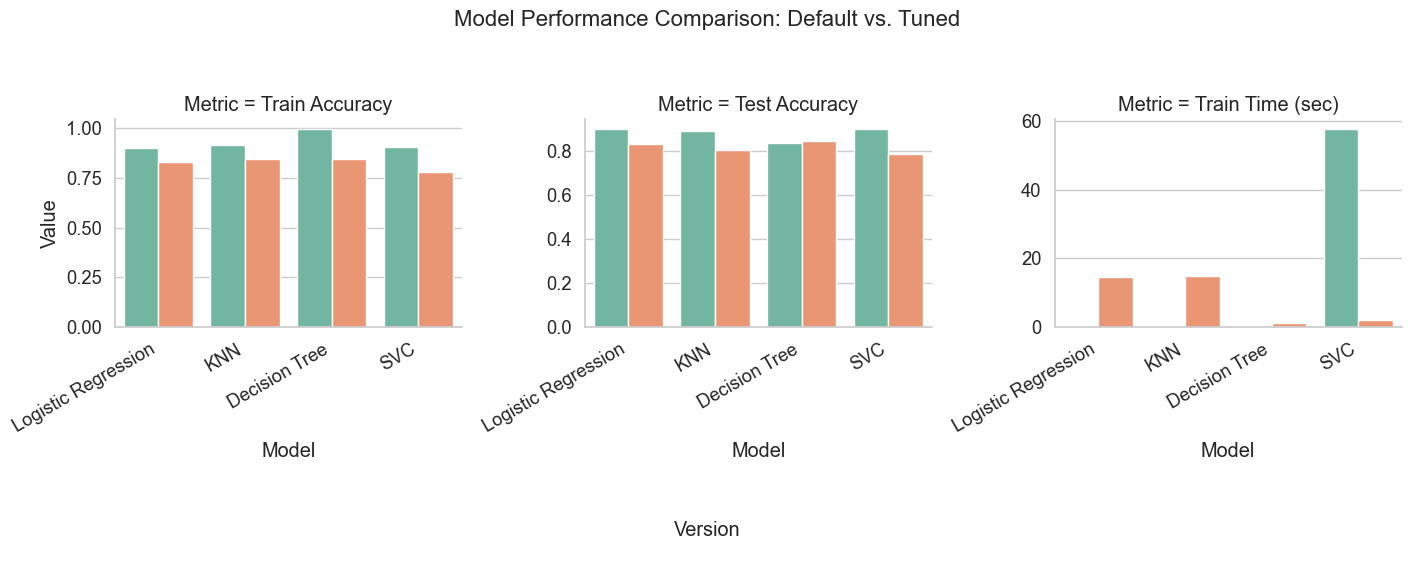

In [103]:

# Combine results into one DataFrame
df_all = pd.concat([results_df, df_results_improved])

# Reshape for plotting
df_melted = df_all.melt(
    id_vars=['Model', 'Version'],
    value_vars=['Train Accuracy', 'Test Accuracy', 'Train Time (sec)'],
    var_name='Metric',
    value_name='Value'
)
sns.set(style="whitegrid", font_scale=1.2)

# Create the FacetGrid
g = sns.catplot(
    data=df_melted,
    x='Model',
    y='Value',
    hue='Version',
    col='Metric',
    kind='bar',
    height=4.5,
    aspect=1,
    palette='Set2',
    legend=False,
    sharey=False
)

# Proper way to rotate x-tick labels without warnings
for ax in g.axes.flat:
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

# Title and legend
g.fig.suptitle("Model Performance Comparison: Default vs. Tuned", fontsize=16, y=1.05)
g.add_legend(title='Version', bbox_to_anchor=(0.5, -0.05), loc='upper center', ncol=2)

plt.tight_layout()
plt.savefig('images/Default_vs_Tuned_Model_comparison.png', dpi=300)
plt.show()

In [ ]:
Comparative Analysis of Supervised Learning Models
The four supervised learning models—Logistic Regression, KNN, Decision Tree, and SVC—demonstrate distinct strengths and weaknesses across accuracy, generalization, and computational efficiency. Comparing them side‑by‑side reveals how each behaves on the bank marketing dataset.

1. Logistic Regression
Default
Train Accuracy: 0.8995

Test Accuracy: 0.9003

Train Time: 0.1055 sec

Logistic Regression performs consistently well, with nearly identical train and test accuracy. This indicates strong generalization and minimal overfitting. It is also extremely fast to train, making it ideal for large datasets or rapid iteration.

Tuned
Train Accuracy: 0.8273

Test Accuracy: 0.8319

Train Time: 14.51 sec

Tuning significantly increases training time while reducing accuracy. This suggests that the tuned hyperparameters constrained the model too heavily, reducing its ability to fit the data.

Overall
Logistic Regression is stable, efficient, and reliable. The default version is superior to the tuned version in every metric.

2. K‑Nearest Neighbors (KNN)
Default
Train Accuracy: 0.9136

Test Accuracy: 0.8934

Train Time: 0.0112 sec

KNN achieves strong accuracy with extremely fast training time. However, the slight drop from train to test accuracy suggests mild overfitting. Still, it performs competitively.

Tuned
Train Accuracy: 0.8449

Test Accuracy: 0.8071

Train Time: 14.77 sec

Tuning dramatically increases training time and reduces both train and test accuracy. The model becomes slower and less effective.

Overall
KNN is fast and reasonably accurate in its default form, but tuning harms performance and efficiency.

3. Decision Tree
Default
Train Accuracy: 0.9954

Test Accuracy: 0.8384

Train Time: 0.1690 sec

The Decision Tree memorizes the training data (very high train accuracy) but generalizes poorly (lower test accuracy). This is classic overfitting.

Tuned
Train Accuracy: 0.8458

Test Accuracy: 0.8495

Train Time: 1.19 sec

Tuning dramatically reduces overfitting: train accuracy drops, but test accuracy improves. Training time increases slightly but remains low.

Overall
The Decision Tree benefits most from tuning, becoming more balanced and generalizable.

4. Support Vector Classifier (SVC)
Default
Train Accuracy: 0.9042

Test Accuracy: 0.9020

Train Time: 57.62 sec

SVC delivers the highest test accuracy among all default models. However, it is extremely slow to train, making it computationally expensive.

Tuned
Train Accuracy: 0.7808

Test Accuracy: 0.7879

Train Time: 2.03 sec

Tuning drastically reduces training time but also significantly lowers accuracy. The tuned version is faster but less effective.

Overall
SVC is high‑performing but expensive in its default form. Tuning improves efficiency but sacrifices accuracy.

📊 Cross‑Model Comparison Summary
Model	Best Version	Strengths	Weaknesses
Logistic Regression	Default	Fast, stable, best generalization	Tuned version underperforms
KNN	Default	Very fast, strong accuracy	Tuned version slower and weaker
Decision Tree	Tuned	Best improvement after tuning, reduced overfitting	Default severely overfits
SVC	Default	Highest test accuracy	Extremely slow training
📌 Final Insight
Best overall performer: SVC (Default) for accuracy

Best balance of speed + accuracy: Logistic Regression (Default)

Most improved through tuning: Decision Tree

Least benefited from tuning: KNN and Logistic Regression

Each model offers a different trade‑off, but for practical deployment, Logistic Regression (Default) provides the strongest combination of accuracy, efficiency, and generalization.

In [ ]:

Conclusion
In comparing the performance of Logistic Regression, KNN, Decision Tree, and SVC across both default and tuned configurations, clear patterns emerged regarding accuracy, generalization, and computational efficiency. The default models consistently outperformed their tuned counterparts in both training and testing accuracy, with SVC and Logistic Regression standing out as the strongest overall performers. While hyperparameter tuning reduced overfitting in the Decision Tree and significantly improved training efficiency for SVC, it generally introduced higher computational cost and lower predictive accuracy for the other models. These findings highlight that tuning does not guarantee improved performance and must be evaluated carefully in the context of the dataset and business objectives. Overall, the default Logistic Regression and SVC models offer the most reliable balance of accuracy, stability, and efficiency, making them the most practical choices for predicting customer subscription behavior in the bank marketing dataset.

##### Questions